In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# topic_0 = np.array([100,100,100,0,0,0,0,0,0])
# topic_1 = np.array([100,0,0,100,0,0,100,0,0])
# topic_2 = np.array([0,0,100,0,0,100,0,0,100])
# topic_3 = np.array([0,100,0,0,100,0,0,100,0])

In [3]:
# t0_dist = topic_0.reshape(1,-1) / np.sum(topic_0)
# t1_dist = topic_1.reshape(1,-1) / np.sum(topic_1)
# t2_dist = topic_2.reshape(1,-1) / np.sum(topic_2)
# t3_dist = topic_3.reshape(1,-1) / np.sum(topic_3)

In [747]:
topic_0 = np.array([100,100,0,0]).reshape(2,2)
topic_1 = np.array([0,0,100,100]).reshape(2,2)
topic_2= np.array([100,0,100,0]).reshape(2,2)

In [748]:
t0_dist = topic_0.reshape(1,-1) / np.sum(topic_0)
t1_dist = topic_1.reshape(1,-1) / np.sum(topic_1)
t2_dist = topic_2.reshape(1,-1) / np.sum(topic_2)

In [749]:
tdists = [t0_dist, t1_dist, t2_dist]
tdists = [np.squeeze(item) for item in tdists]
num_topics = len(tdists)

In [770]:
num_images = 100
num_words = 20
dim = 2

In [771]:
w_corp = []
z_corp = []

for iter in range(num_images):
    dir_draw = np.random.dirichlet([1] * num_topics, 1)[0]
    mult_draw = np.random.multinomial(num_words, pvals = dir_draw)
    w_i = np.zeros(num_words)
    z_i = np.zeros(num_words)
    i = 0
    for t, count in enumerate(mult_draw):
        words = np.random.choice(dim * dim, size=count, p=tdists[t])
        for j, word in enumerate(words):
            w_i[i] = words[j]
            z_i[i] = t
            i += 1 
    w_i, z_i = shuffle(w_i, z_i, random_state=0)
    w_corp.append(w_i)
    z_corp.append(z_i)
w_corp = np.array(w_corp)
z_corp = np.array(z_corp)

In [772]:
len(w_corp[0])

20

In [782]:
def to_image(w_i):
    unique, counts = np.unique(w_i, return_counts=True)
    print(f'counts: {counts}')
    print(f'unique: {unique}')
    freqs = np.zeros(dim * dim)
    for num, ct in zip(unique, counts):
        freqs[int(num)] = ct
    plt.imshow(freqs.reshape(dim, dim))

In [783]:
w_corp[0]

array([0., 0., 0., 1., 0., 0., 1., 2., 0., 1., 1., 3., 0., 0., 2., 0., 1.,
       1., 3., 2.])

counts: [9 6 3 2]
unique: [0. 1. 2. 3.]


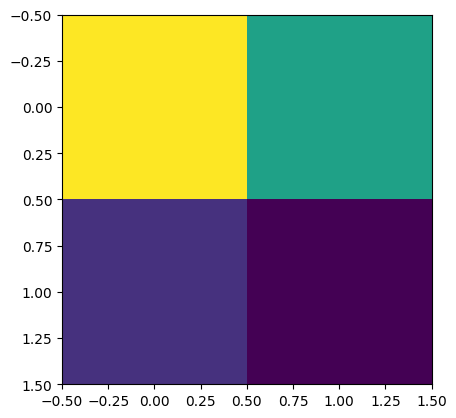

In [784]:
to_image(w_corp[0])

In [785]:
topic_assignments = np.random.randint(0,num_topics,size=num_images * num_words)
len(topic_assignments)

2000

In [786]:
topic_assignments = topic_assignments.reshape(num_images, num_words)

In [787]:
beta = 1
alpha = 1

In [788]:
def draw_fcd(words, topic_assigns, ind):
    d = math.floor(ind / num_words)
    w_ind = ind - d * num_words
    word = int(w_corp[d, w_ind])
    # print(f'topic: {z_corp[d, w_ind]}')
    # print(f'word: {word}')
    curr_topic_assign = int(z_corp[d, w_ind])
    tprob_unweighted = np.zeros(num_topics)
    partial_w = np.delete(words.reshape(1,-1), ind)
    partial_z = np.delete(topic_assigns.reshape(1,-1), ind)
    for t in range(num_topics):
        #njdot and njw
        words_in_topic = partial_w[partial_z == t]
        njdot = len(words_in_topic)
        unique, counts = np.unique(words_in_topic, return_counts=True)
        ind_of_word = np.argwhere(unique == word)
        njw = 0
        if len(ind_of_word):
            ind_of_word = ind_of_word[0][0]
            count_of_word = counts[ind_of_word]
            njw = count_of_word

        # within document
        curr_doc_z = np.delete(topic_assigns[d], w_ind)
        njd = len(np.where(curr_doc_z == t)[0])
        nddot = num_words - 1


        # print(f'njw: {njw} njdot: {njdot} njd: {njd} nddot: {nddot}')
        tprob_unweighted[t] = (njw + beta)*(njd + alpha) / ((njdot + dim * dim * beta)*(nddot + num_topics * alpha))
    # print(tprob_unweighted)
    tprob = tprob_unweighted / np.sum(tprob_unweighted)
    # print(tprob)
    return np.random.choice(num_topics, p=tprob)
        
    # print(word)

In [760]:
draw_fcd(w_corp, topic_assignments, 3)

1

In [761]:
# %lprun -f draw_fcd draw_fcd(w_corp, topic_assignments, 19998)

In [26]:
%load_ext line_profiler

In [789]:
topic_assignment_distrs = np.zeros((num_images * num_words, num_topics))

In [790]:
def gibbs_iter(w_corp, state, burn_in=False):
    next_state = state.copy()
    # print(next_state)
    for i in range(num_words * num_images):
        new_state_i = draw_fcd(w_corp, next_state, i)
        d = math.floor(i / num_words)
        w_ind = i - d * num_words
        next_state[d,w_ind] = new_state_i
        if not burn_in:
            topic_assignment_distrs[i, new_state_i] += 1
    return next_state.reshape(num_images, num_words)

In [641]:
w_corp[0]

array([3., 1., 0., 3., 3.])

In [673]:
new_state = gibbs_iter(w_corp, topic_assignments, burn_in=False)
print(new_state[0])
print(topic_assignment_distrs)

[0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0]
[[2. 1.]
 [0. 3.]
 [1. 2.]
 ...
 [2. 1.]
 [2. 1.]
 [3. 0.]]


In [223]:
new = gibbs_iter(w_corp, topic_assignments)

[[1 1 1 0 0]
 [0 0 0 0 0]]


In [147]:
%lprun -f gibbs_iter gibbs_iter(w_corp, topic_assignments)

Timer unit: 1e-09 s

Total time: 15.1167 s
File: /tmp/ipykernel_6637/92699743.py
Function: gibbs_iter at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def gibbs_iter(w_corp, state, burn_in=False):
     2         1    3033360.0    3e+06      0.0      next_state = np.zeros(num_images * num_words)
     3     20001    8323315.0    416.1      0.1      for i in range(0, len(next_state)):
     4     20000        2e+10 752545.7     99.6          new_state_i = draw_fcd(w_corp, state, i)
     5     20000   19534206.0    976.7      0.1          next_state[i] = new_state_i
     6     20000    5051857.0    252.6      0.0          if not burn_in:
     7     20000   29796306.0   1489.8      0.2              topic_assignment_distrs[i, new_state_i] += 1
     8         1       2603.0   2603.0      0.0      return next_state.reshape(num_images, num_words)

Burn in

In [791]:
state = topic_assignments
for i in range(1000):
    if i % 100 == 0:
        print(f'i: {i}')
    state = gibbs_iter(w_corp, state, burn_in=True)

i: 0
i: 100
i: 200
i: 300
i: 400
i: 500
i: 600
i: 700
i: 800
i: 900


In [539]:
w_corp[0]

array([2., 2., 3., 3., 1., 3., 3., 3., 0., 2.])

In [ ]:
for i in range(1000):
    # print(not i % 10 == 0)
    state = gibbs_iter(w_corp, state, burn_in=(not i % 10 == 0))
    if i % 100 == 0:
        print(topic_assignment_distrs[:10])


In [792]:
def calc_phi(words, z_hat, t):
    tprobs = np.zeros(dim * dim)
    words_in_topic = words.reshape(1,-1)[z_hat.reshape(1,-1) == t]
    unique, counts = np.unique(words_in_topic, return_counts=True)
    print(unique)
    print(counts)
    njdot = np.sum(counts)
    print(njdot)
    for word in range(dim * dim):
        numerator = beta
        denom = dim * dim * beta + njdot
        if word in unique:
            numerator += counts[np.where(unique == word)][0]
        tprobs[word] = numerator / denom
    # for w in range(num_topics):
    #     ind_of_word = np.argwhere(unique == w)
    #     njw = 0
    #     if len(ind_of_word):
    #         ind_of_word = ind_of_word[0][0]
    #         count_of_word = counts[ind_of_word]
    #         njw = count_of_word
        # tprobs[t] = (njw + beta) / (njdot + dim * dim * beta)
    print(tprobs.reshape(dim, dim))
        

In [795]:
calc_phi(w_corp, state,0)

[0. 1. 2. 3.]
[339  10 300  16]
665
[[0.50822123 0.01644245]
 [0.44992526 0.02541106]]


In [701]:
w_corp[0]

array([1., 2., 3., 2., 0., 3., 3., 0., 1., 2.])

In [553]:
z_corp[1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [566]:
state.reshape(1,-1)[0][np.where(w_corp.reshape(1,-1)[0]  == 2)]

array([1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1.

In [557]:
np.where(w_corp[0] == 2)

(array([0, 1, 9]),)

In [554]:
state[1]

array([1., 0., 1., 0., 0., 1., 0., 0., 0., 1.])

In [547]:
np.sum(topic_assignment_distrs[10:20], axis=0)

array([520., 480.])

In [612]:
def pred_dist_from_sample(samples):
    distrs = []
    for t in range(num_topics):
        distr = np.zeros(dim * dim)
        for w in range(dim * dim):
            sample_versions = np.zeros(len(samples))
            for i, sample in enumerate(samples):
                # print(sample)
                ntw = np.sum(sample[:,math.floor(w/3), w % 3] == np.ones(num_images) * t)
                njdot = num_images
                sample_versions[i]= (ntw + beta) / (njdot + dim * dim * beta)
            distr[w] = np.mean(sample_versions)
        distrs.append(distr.reshape(dim,dim))
    return distrs

In [613]:
len(samples)

30

In [614]:
pred_dist_from_sample(samples[:100])

[array([[0.23372626, 0.25199738, 0.26155861],
        [0.25042567, 0.25749836, 0.25284872],
        [0.25546824, 0.26797642, 0.25926654]]),
 array([[0.25036018, 0.23863785, 0.23169614],
        [0.21322855, 0.21650295, 0.21669941],
        [0.20720367, 0.18775377, 0.18251473]]),
 array([[0.23903078, 0.24839555, 0.23084479],
        [0.25193189, 0.2540275 , 0.25507531],
        [0.27334643, 0.26313032, 0.25985593]]),
 array([[0.26705959, 0.25114604, 0.26607728],
        [0.2745907 , 0.262148  , 0.26555337],
        [0.25415848, 0.27131631, 0.28853962]])]